Epoch [1/200], Step [5/16], D_X Loss: 0.6872, D_Y Loss: 0.6909, G Loss: 15.5453
Epoch [1/200], Step [10/16], D_X Loss: 0.6817, D_Y Loss: 0.6847, G Loss: 15.3274
Epoch [1/200], Step [15/16], D_X Loss: 0.6765, D_Y Loss: 0.6805, G Loss: 15.5422
Epoch [2/200], Step [5/16], D_X Loss: 0.6722, D_Y Loss: 0.6751, G Loss: 15.0421
Epoch [2/200], Step [10/16], D_X Loss: 0.6645, D_Y Loss: 0.6685, G Loss: 15.4908
Epoch [2/200], Step [15/16], D_X Loss: 0.6614, D_Y Loss: 0.6655, G Loss: 14.7578
Epoch [3/200], Step [5/16], D_X Loss: 0.6567, D_Y Loss: 0.6561, G Loss: 14.6227
Epoch [3/200], Step [10/16], D_X Loss: 0.6510, D_Y Loss: 0.6512, G Loss: 14.1341
Epoch [3/200], Step [15/16], D_X Loss: 0.6438, D_Y Loss: 0.6456, G Loss: 14.0683
Epoch [4/200], Step [5/16], D_X Loss: 0.6409, D_Y Loss: 0.6427, G Loss: 13.6355
Epoch [4/200], Step [10/16], D_X Loss: 0.6323, D_Y Loss: 0.6343, G Loss: 12.9838
Epoch [4/200], Step [15/16], D_X Loss: 0.6405, D_Y Loss: 0.6334, G Loss: 12.1494
Epoch [5/200], Step [5/16], D_X 

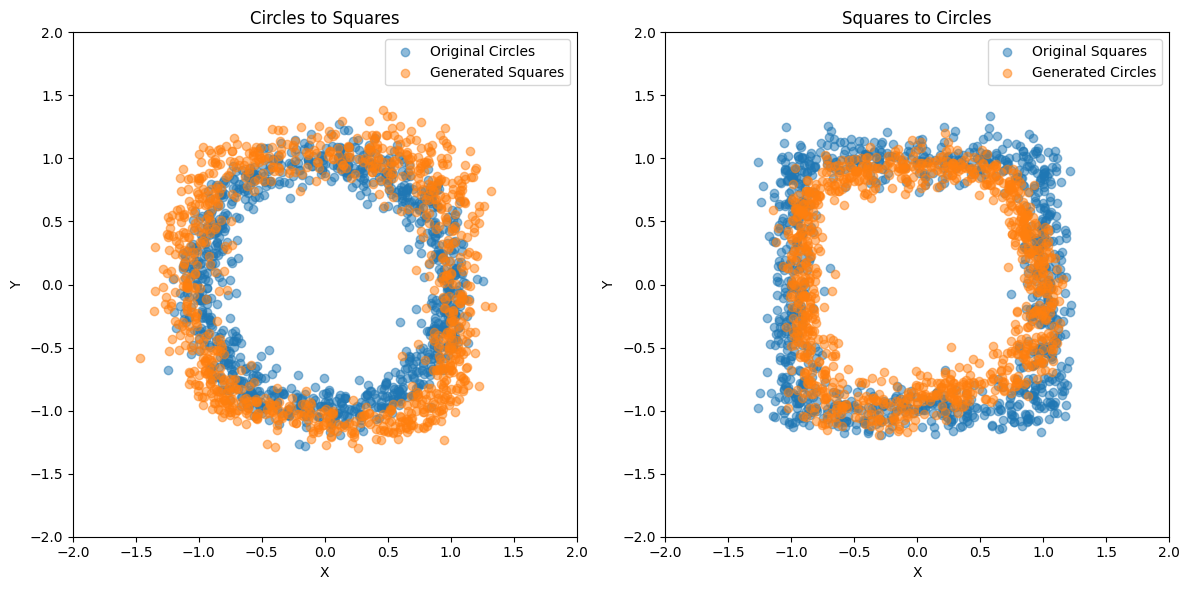

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# --- 1. Define the Datasets ---

class CircleDataset(Dataset):
    def __init__(self, num_samples, radius=1, noise=0.1, transform=None):
        self.num_samples = num_samples
        self.radius = radius
        self.noise = noise
        self.transform = transform
        self.data = self.generate_data()

    def generate_data(self):
        angles = np.random.uniform(0, 2 * np.pi, self.num_samples)
        x = self.radius * np.cos(angles) + np.random.normal(0, self.noise, self.num_samples)
        y = self.radius * np.sin(angles) + np.random.normal(0, self.noise, self.num_samples)
        data = np.stack([x, y], axis=1).astype(np.float32)
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample


class SquareDataset(Dataset):
    def __init__(self, num_samples, side_length=2, noise=0.1, transform=None):
        self.num_samples = num_samples
        self.side_length = side_length
        self.noise = noise
        self.transform = transform
        self.data = self.generate_data()

    def generate_data(self):
        data = np.zeros((self.num_samples, 2), dtype=np.float32)
        for i in range(self.num_samples):
            # Choose a random edge of the square
            edge = np.random.randint(0, 4)
            if edge == 0:  # Top edge
                x = np.random.uniform(-self.side_length/2, self.side_length/2)
                y = self.side_length/2
            elif edge == 1:  # Right edge
                x = self.side_length/2
                y = np.random.uniform(-self.side_length/2, self.side_length/2)
            elif edge == 2:  # Bottom edge
                x = np.random.uniform(-self.side_length/2, self.side_length/2)
                y = -self.side_length/2
            else:  # Left edge
                x = -self.side_length/2
                y = np.random.uniform(-self.side_length/2, self.side_length/2)

            data[i, 0] = x + np.random.normal(0, self.noise)
            data[i, 1] = y + np.random.normal(0, self.noise)
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample


# --- 2. Define the Models ---

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# --- 3. Training Loop ---

def train():
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.0002
    num_epochs = 200
    lambda_cycle = 10  # Weight for cycle consistency loss
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Datasets and DataLoaders
    #transform = transforms.ToTensor() # this does nothing for numpy arrays, but keep it consistent
    circle_dataset = CircleDataset(num_samples=1000) #, transform=transform)
    square_dataset = SquareDataset(num_samples=1000) #, transform=transform)

    circle_loader = DataLoader(circle_dataset, batch_size=batch_size, shuffle=True)
    square_loader = DataLoader(square_dataset, batch_size=batch_size, shuffle=True)

    # Models
    G_XtoY = Generator().to(device)  # Generator: Circle -> Square
    G_YtoX = Generator().to(device)  # Generator: Square -> Circle
    D_X = Discriminator().to(device)   # Discriminator for Circle
    D_Y = Discriminator().to(device)   # Discriminator for Square

    # Optimizers
    optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=learning_rate)
    optimizer_D_X = optim.Adam(D_X.parameters(), lr=learning_rate)
    optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=learning_rate)

    # Loss function
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(num_epochs):
        for i, (real_X, real_Y) in enumerate(zip(circle_loader, square_loader)):  # Changed to zip to ensure both datasets are used
            #real_X = real_X.to(device)
            #real_Y = real_Y.to(device)

            real_X = real_X.float().to(device) # Cast to float and move to device
            real_Y = real_Y.float().to(device) # Cast to float and move to device


            # Labels for discriminator
            real_label = torch.ones((real_X.size(0), 1)).to(device)
            fake_label = torch.zeros((real_X.size(0), 1)).to(device)


            # --- Train Discriminators ---
            # 1. Train Discriminator X (Circle)
            optimizer_D_X.zero_grad()
            output_real_X = D_X(real_X)
            loss_D_real_X = criterion(output_real_X, real_label)

            fake_X = G_YtoX(real_Y)  # Generate fake Circles from Squares
            output_fake_X = D_X(fake_X.detach())  # Detach to prevent generator updates
            loss_D_fake_X = criterion(output_fake_X, fake_label)

            loss_D_X = (loss_D_real_X + loss_D_fake_X) / 2
            loss_D_X.backward()
            optimizer_D_X.step()

            # 2. Train Discriminator Y (Square)
            optimizer_D_Y.zero_grad()
            output_real_Y = D_Y(real_Y)
            loss_D_real_Y = criterion(output_real_Y, real_label)

            fake_Y = G_XtoY(real_X) # Generate fake Squares from Circles
            output_fake_Y = D_Y(fake_Y.detach()) # Detach to prevent generator updates
            loss_D_fake_Y = criterion(output_fake_Y, fake_label)

            loss_D_Y = (loss_D_real_Y + loss_D_fake_Y) / 2
            loss_D_Y.backward()
            optimizer_D_Y.step()


            # --- Train Generators ---
            optimizer_G.zero_grad()

            # 1. Adversarial Loss
            fake_Y = G_XtoY(real_X) # Generate fake Squares from Circles
            output_fake_Y = D_Y(fake_Y)
            loss_G_XtoY = criterion(output_fake_Y, real_label)

            fake_X = G_YtoX(real_Y) # Generate fake Circles from Squares
            output_fake_X = D_X(fake_X)
            loss_G_YtoX = criterion(output_fake_X, real_label)

            # 2. Cycle Consistency Loss
            reconstructed_X = G_YtoX(fake_Y) # Reconstruct Circles from fake Squares
            loss_cycle_X = torch.mean(torch.abs(reconstructed_X - real_X)) # L1 loss

            reconstructed_Y = G_XtoY(fake_X) # Reconstruct Squares from fake Circles
            loss_cycle_Y = torch.mean(torch.abs(reconstructed_Y - real_Y)) # L1 loss


            # Total Generator Loss
            loss_G = loss_G_XtoY + loss_G_YtoX + lambda_cycle * (loss_cycle_X + loss_cycle_Y)
            loss_G.backward()
            optimizer_G.step()

            if (i+1) % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(circle_loader)}], "
                      f"D_X Loss: {loss_D_X.item():.4f}, D_Y Loss: {loss_D_Y.item():.4f}, "
                      f"G Loss: {loss_G.item():.4f}")


    # --- 4. Visualization ---
    with torch.no_grad():
        # Generate data from the learned mapping
        num_samples = 1000
        circle_dataset = CircleDataset(num_samples=num_samples)  # No transform needed for plotting
        square_dataset = SquareDataset(num_samples=num_samples)

        circle_data = torch.tensor(circle_dataset.data).to(device).float()
        square_data = torch.tensor(square_dataset.data).to(device).float()

        generated_squares = G_XtoY(circle_data).cpu().numpy()
        generated_circles = G_YtoX(square_data).cpu().numpy()

        # Plotting
        plt.figure(figsize=(12, 6))

        # Original Circle and Generated Square
        plt.subplot(1, 2, 1)
        plt.scatter(circle_dataset.data[:, 0], circle_dataset.data[:, 1], label="Original Circles", alpha=0.5)
        plt.scatter(generated_squares[:, 0], generated_squares[:, 1], label="Generated Squares", alpha=0.5)
        plt.title("Circles to Squares")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.xlim(-2, 2) # Adjust limits for better visualization
        plt.ylim(-2, 2)

        # Original Square and Generated Circle
        plt.subplot(1, 2, 2)
        plt.scatter(square_dataset.data[:, 0], square_dataset.data[:, 1], label="Original Squares", alpha=0.5)
        plt.scatter(generated_circles[:, 0], generated_circles[:, 1], label="Generated Circles", alpha=0.5)
        plt.title("Squares to Circles")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.xlim(-2, 2) # Adjust limits for better visualization
        plt.ylim(-2, 2)

        plt.tight_layout()
        plt.show()




if __name__ == "__main__":
    train()